# What is TF-IDF?


**TF-IDF** is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

It has many uses, most importantly in automated text analysis, and is very useful for scoring words in machine learning algorithms for Natural Language Processing (NLP).

TF-IDF (**term frequency-inverse document frequency**) was invented for document search and information retrieval. It works by increasing proportionally to the number of times a word appears in a document, but is offset by the number of documents that contain the word. So, words that are common in every document, such as this, what, and if, rank low even though they may appear many times, since they don’t mean much to that document in particular.

However, if the word Bug appears many times in a document, while not appearing many times in others, it probably means that it’s very relevant. For example, if what we’re doing is trying to find out which topics some NPS responses belong to, the word Bug would probably end up being tied to the topic Reliability, since most responses containing that word would be about that topic.

### ***Math behind TF-IDF...***
**TF-IDF** for a word in a document is calculated by multiplying two different metrics:

- The **term frequency** of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are ways to adjust the frequency, by length of a document, or by the raw frequency of the most frequent word in a document.
- The **inverse document frequency** of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.

So, if the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1.
Multiplying these two numbers results in the **TF-IDF score** of a word in a document. The higher the score, the more relevant that word is in that particular document.



## LIBRARIES

In [1]:
#basics
import numpy as np
import pandas as pd

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model

#text_processing
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer

# General libraries
import re, os, string
import pandas as pd

# Scikit-learn importings
from sklearn.feature_extraction.text import TfidfVectorizer

#other
from tqdm import tqdm
import gc

#warnings
import warnings
warnings.filterwarnings("ignore")

# Code

In [3]:
def sort_coo(coo_matrix):
    """Sort a dict with highest score"""
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature, score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [4]:
def get_keywords(vectorizer, feature_names, doc):
    """Return top k keywords from a doc using TF-IDF method"""

    #generate tf-idf for the given document
    tf_idf_vector = vectorizer.transform([doc])
    
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only TOP_K_KEYWORDS
    keywords=extract_topn_from_vector(feature_names,sorted_items,TOP_K_KEYWORDS)
    
    return list(keywords.keys())

# Reading data

In [2]:
# Constants
PUNCTUATION = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~""" 
TOP_K_KEYWORDS = 10 # top k number of keywords to retrieve in a ranked document
STOPWORD_PATH = "/kaggle/input/stopwords/stopwords.txt"
PAPERS_PATH = "/kaggle/input/question-pairs-dataset/questions.csv"

In [3]:
df = pd.read_csv(PAPERS_PATH)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [5]:
df.dropna(inplace=True)

## EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404348 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404348 non-null  int64 
 1   qid1          404348 non-null  int64 
 2   qid2          404348 non-null  int64 
 3   question1     404348 non-null  object
 4   question2     404348 non-null  object
 5   is_duplicate  404348 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


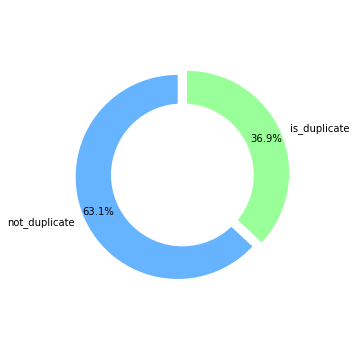

In [10]:
# pie chart to visualize the distribution of duplicates

targets = df['is_duplicate'].value_counts()


labels = ['not_duplicate', 'is_duplicate']
sizes = targets.values.tolist()

#colors
colors = ['#66b3ff', '#99ff99'] 

 
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = (0.05,0.05))
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout();

The number of questions which are not duplicated is close to double of question which are duplicates. So there is significant imbalance

# 🧹 Data Preprocessing

In [7]:
def clean_text(text):
    """Doc cleaning"""
    
    # Lowering text
    text = text.lower()
    
    # Removing punctuation
    text = "".join([c for c in text if c not in PUNCTUATION])
    
    # Removing whitespace and newlines
    text = re.sub('\s+',' ',text)
    
    return text

In [8]:
df['new_ques1']=df['question1'].apply(clean_text)
df['new_ques2']=df['question2'].apply(clean_text)

In [9]:
#lower casing
def lower_casing(text):
    text=text.lower()
    return text

In [10]:
df['new_ques1']=df['question1'].apply(lower_casing)
df['new_ques2']=df['question2'].apply(lower_casing)

In [11]:
# Replacing Symbols and Short forms

In [12]:
def replacements(text):

    text=text.replace('=', ' is equal to ')
    text=text.replace('%', ' percent ')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('+', ' plus ')
    text = text.replace('/', ' or ')
    text = text.replace('-', ' ')
    text = text.replace('[math]', '')
    
    #replacement dict
    replacements_dict = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
         "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'd've": "I would have",
        "I'll": "I will",
        "I'll've": "I will have",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
          "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so is",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
         "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
         "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have",
    }

    # Apply replacements
    pattern = re.compile(r'\b(' + '|'.join(replacements_dict.keys()) + r')\b')
    text = pattern.sub(lambda x: replacements_dict[x.group()], text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    return text

In [13]:
df['new_ques1']=df['new_ques1'].apply(replacements)
df['new_ques2']=df['new_ques2'].apply(replacements)

In [14]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word.strip()) for word in text.split()])


In [15]:
pbar = tqdm(total=len(df), desc='Lemmatizing question1')
df['new_ques1'] = df['new_ques1'].apply(lambda x: (pbar.update(1), lemmatize_words(x))[1])
pbar.close()


Lemmatizing question1: 100%|██████████| 404348/404348 [00:25<00:00, 16048.59it/s]


In [16]:
pbar = tqdm(total=len(df), desc='Lemmatizing question2')
df['new_ques2'] = df['new_ques2'].apply(lambda x: (pbar.update(1), lemmatize_words(x))[1])
pbar.close()


Lemmatizing question2: 100%|██████████| 404348/404348 [00:23<00:00, 17011.30it/s]


### Removing Stopwords

In [17]:
stop_words=stopwords.words('english')

def remove_stopwords(text):

    new_text=[]

    for word in text.split():

        if word in stop_words:
            new_text.append('')

        else:
            new_text.append(word.strip())

    x=new_text[:]
    new_text.clear()
    return ' '.join(x)

In [18]:
pbar = tqdm(total=len(df), desc='Removing Stopwords:')
df['new_ques1'] = df['new_ques1'].apply(lambda x: (pbar.update(1), remove_stopwords(x))[1])
df['new_ques2'] = df['new_ques2'].apply(lambda x: (pbar.update(1), remove_stopwords(x))[1])
pbar.close()

Removing Stopwords:: 808696it [00:25, 31587.52it/s]                            


In [19]:
example=np.random.randint(len(df))
print(df['question1'][example])
print(df['new_ques1'][example])

What do the people of Pakistan think of the killing of Mullah Mansour inside Pakistan?
   people  pakistan think   killing  mullah mansour inside pakistan


In [20]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,new_ques1,new_ques2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india,step step guide invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,story kohinoor koh noor diamond,would happen indian government stole kohin...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increase speed internet connection usin...,internet speed increased hacking dns
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mentally lonely solve,find remainder 2324 math divided 2423
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolve water quikly sugar salt methane...,fish would survive salt water


# Keywords Extraction using TF-IDF

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [22]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['new_ques1'], df['is_duplicate'], test_size=0.2, random_state=42)

In [23]:
# Vectorize the questions using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [25]:
print("X_train shape:", X_train_tfidf.shape)
print("X_test shape:", X_test_tfidf.shape)


X_train shape: (323478, 58418)
X_test shape: (80870, 58418)


In [26]:
# Train a supervised algorithm (e.g., Logistic Regression) on the training set
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [27]:
# Evaluate the model on the testing set
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7407073080252257


# Result 🔥

In [29]:
# Predict the similarity between new pairs of questions
new_questions = ["How can I learn machine learning?", "What are the best resources to learn machine learning?"]
new_questions_tfidf = vectorizer.transform(new_questions)
similarity_scores = model.predict_proba(new_questions_tfidf)[:, 1]  # Assuming binary classification, get probability of class 1
print("Similarity Scores:", similarity_scores)

Similarity Scores: [0.6239561  0.77812849]
